### A linear regression dataset, with a easy to see patchwork solution and an invariant one.
##### The And-mask and the geometric mean of gradients converge to the consistent solutions, average gradients to patchwork solutions. 
Each datapoint is an environment. Each environment $i$ has a strong signal on the $i$-th dimension, and a weak signal in the last dimension.

In [2]:
import torch
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
np.set_printoptions(precision=5, suppress=True)

In [3]:
ADD_SMALL_NOISE = False

# Create the dataset.
x = 3 * torch.cat((torch.eye(4), 0.1 * torch.ones(4).view(-1,1)), dim=1)
y = torch.tensor([1., 1., 1., 1.]).float()

if ADD_SMALL_NOISE:
    dist = torch.distributions.Uniform(-0.001, 0.001)
    
    # This adds noise on all non-robust feature
    x[:, :-1] += dist.sample(x[:, :-1].shape)
    
    # This adds noise on every feature
    #     x += dist.sample(x.shape)

print('x:', x.numpy(), sep="\n")
print('y: ', y.view(-1, 1).numpy(), sep="\n")


x:
[[3.  0.  0.  0.  0.3]
 [0.  3.  0.  0.  0.3]
 [0.  0.  3.  0.  0.3]
 [0.  0.  0.  3.  0.3]]
y: 
[[1.]
 [1.]
 [1.]
 [1.]]


### The last feature is the only robust one (it can be found in any environment), but it produces a weaker signal, and has a higher cost using weight decay.

In [33]:
def add_l1_grads(l1_coef = 1e-4 , thetas = None):
    return l1_coef*torch.sign(thetas)

def add_l2_grads(l2_coef = 1e-4, thetas= None):
    return thetas * 2*l2_coef

def add_l1(l1_coef = 1e-4 , thetas = None):
    return (l1_coef*torch.abs(thetas)).mean()

def add_l2(l2_coef = 1e-4, thetas= None):
    return (l2_coef*(thetas**2)).mean()

def loss_fn(_x, theta, y):
    x = deepcopy(_x)
    if x.ndim == 1:
        x = x.view(1, -1)
    return torch.sum(0.5 * (x @ theta - y) ** 2) / x.shape[0]


def get_losses(thetas, x, y):
    losses = []
    with torch.no_grad():
        for theta in thetas:
            losses.append(loss_fn(x, theta, y).item())
    return losses


def opt(x, y, method, lr, weight_decay, n_iters, verbose=False):
    thetas, iters, losses = [], [0], []
    theta = torch.randn(5, requires_grad=True) * 0.1
    thetas.append(theta.data.numpy())
    
    with torch.no_grad():
        loss = loss_fn(x, theta, y)
        losses.append(loss.item())
    
    for i in range(n_iters + 1):
        lr *= 0.9995
        
        grads = []
        loss_e = 0.
        for e in range(x.shape[0]):
            loss_e = loss_fn(x[e], theta, y[e])
            grad_e = torch.autograd.grad(loss_e, theta)[0]
            grads.append(grad_e)

        grad = torch.stack(grads, dim=-1)
        
        if method == 'geom_mean':
            n_agreement_domains = len(grads)
            signs = torch.sign(grad) 
            mask = torch.abs(signs.mean(dim=-1)) == 1
            avg_grad = grad.mean(dim=-1) * mask
            prod_grad = torch.sign(avg_grad) * \
                        torch.exp(torch.sum(torch.log(torch.abs(grad) + 1e-10), dim=1)) \
                        ** (1. / n_agreement_domains)
            final_grads = prod_grad
        elif method == 'and_mask':
            signs = torch.sign(grad) 
            mask = torch.abs(signs.mean(dim=-1)) == 1
            avg_grad = grad.mean(dim=-1) * mask
            final_grads = avg_grad
        elif method == 'and_mask_l1':
            signs = torch.sign(grad) 
            mask = torch.abs(signs.mean(dim=-1)) == 1
            avg_grad = grad.mean(dim=-1) * mask
            final_grads = avg_grad
            l1 = add_l1_grads(thetas=theta)
            final_grads += l1
        elif method == 'and_mask_l2':
            signs = torch.sign(grad) 
            mask = torch.abs(signs.mean(dim=-1)) == 1
            avg_grad = grad.mean(dim=-1) * mask
            final_grads = avg_grad
            l2 = add_l2_grads(thetas=theta)
            final_grads += l2
        elif method == 'and_mask_elastic':
            signs = torch.sign(grad) 
            mask = torch.abs(signs.mean(dim=-1)) == 1
            avg_grad = grad.mean(dim=-1) * mask
            final_grads = avg_grad
            l1 = add_l1_grads(thetas=theta)
            l2 = add_l2_grads(thetas=theta)
            final_grads += l1 + l2
        elif method == 'arithm_mean':
            avg_grad = grad.mean(dim=-1)
            final_grads = avg_grad
        else:
            raise ValueError()
            
        theta = theta - lr * (final_grads + weight_decay*theta)
        
        if not i % (n_iters // 200):
            thetas.append(theta.data.numpy())
            iters.append(i)
            with torch.no_grad():
                loss = loss_fn(x, theta, y)
                if method == 'and_mask_l1':
                    loss += add_l1(thetas=theta)
                elif method == 'and_mask_l2':
                    loss += add_l2(thetas=theta)
                elif method == 'and_mask_elastic':
                    loss += add_l1(thetas=theta) + add_l2(thetas=theta)
                elif method == 'arithm_mean':
                    pass
                losses.append(loss.item())

        
        if not i % (n_iters // 5):
            print(".", end="")
            with torch.no_grad():
                loss = loss_fn(x, theta, y)
                if method == 'and_mask_l1':
                    loss += add_l1(thetas=theta)
                elif method == 'and_mask_l2':
                    loss += add_l2(thetas=theta)
                elif method == 'and_mask_elastic':
                    loss += add_l1(thetas=theta) + add_l2(thetas=theta)
                elif method == 'arithm_mean':
                    pass
                if verbose:
                    print(f"loss: {loss.item():.6f}, theta: {theta.data.numpy()}, it: {i}")
              
    with torch.no_grad():
        loss = loss_fn(x, theta, y)
        if method == 'and_mask_l1':
            loss += add_l1(thetas=theta)
        elif method == 'and_mask_l2':
            loss += add_l2(thetas=theta)
        elif method == 'and_mask_elastic':
            loss += add_l1(thetas=theta) + add_l2(thetas=theta)
        elif method == 'arithm_mean':
            pass
        print(f"loss: {loss.item():.6f}, theta: {theta.data.numpy()}, it: {i}")
    return np.stack(thetas), iters, losses


In [23]:
# Some plotting code

def show_weights_evolution(t_all, t_1, t_2, iters):
    scale = 3.

    min_y = min(t_all.min(), t_1.min(), t_2.min()) * 1.1
    max_y = max(t_all.max(), t_1.max(), t_2.max()) * 1.1

    fig, axs = plt.subplots(1, x.shape[1], figsize=((x.shape[1] + 1) * scale, scale))
    for weight_idx in range(x.shape[1]):
        axs[weight_idx].plot(iters, t_all[:, weight_idx], lw=3)
        axs[weight_idx].plot(iters, t_1[:, weight_idx], ls='--', lw=3)
        axs[weight_idx].plot(iters, t_2[:, weight_idx], ls='--', lw=3)
        axs[weight_idx].grid()
        axs[weight_idx].set_ylim([min_y, max_y])
        axs[weight_idx].set_title(f"weight {weight_idx}")
        axs[weight_idx].set_xlabel(f"iterations")
    plt.show()
    

def plot_loss(losses, test_losses=None):
    plt.figure()
    plt.plot(range(1, len(losses)+1), losses, label='train loss')
    if test_losses is not None:
        plt.plot(range(1, len(losses)+1), test_losses, label='test loss')
    plt.xscale('log')
    plt.legend()
    plt.show()


### In the next cell, experiment with different values of `method` in: `['and_mask', 'geom_mean', 'arithm_mean']` 

In [24]:
def run_method(method):

    torch.manual_seed(0)
    np.random.seed(0)

    lr = .3
    weight_decay = .00
    n_iters = 1000

    print(f'\nMethod: {method} = = = Train on all 4 envs')
    t_all, iters, loss_all = opt(x, y, method, lr, weight_decay, n_iters)
    plot_loss(loss_all)

    print(f'\nMethod: {method}= = = Train on first 2 envs')
    t_1, iters, loss_p1 = opt(x[:2], y[:2], method, lr, weight_decay, n_iters)
    test_loss_p1 = get_losses(t_1, x[2:], y[2:])
    plot_loss(loss_p1, test_loss_p1)

    print(f'\nMethod: {method}= = = Train on last 2 envs')
    t_2, iters, loss_p2 = opt(x[2:], y[2:], method, lr, weight_decay, n_iters)
    test_loss_p2 = get_losses(t_2, x[:2], y[:2])
    plot_loss(loss_p2, test_loss_p2)

    print("How every weight evolves during training. Dashed lines are trained on first 2 or last 2 envs")
    show_weights_evolution(t_all, t_1, t_2, iters)

Here we run classic GD (i.e. with average gradients), on three sets of environments. First, on all 4 envs, then on the first 2, and finally on the last 2. The test loss is computed on the left out environments.

As shown by the last thetas after each training run, optimization converges to three distinct solutions (the patchwork solutions), with high test losses on those left out.

E.g., training on the first pair of envs, we converge approximately to [0.33, 0.33, 0, 0, 0.05]


Method: arithm_mean = = = Train on all 4 envs
......loss: 0.000009, theta: [0.3201  0.3201  0.3201  0.3201  0.11819], it: 1000


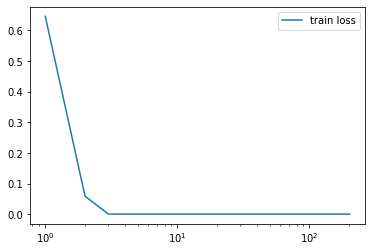


Method: arithm_mean= = = Train on first 2 envs
......loss: 0.000002, theta: [ 0.32637  0.32637  0.00788 -0.00676  0.06242], it: 1000


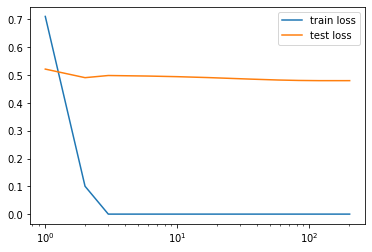


Method: arithm_mean= = = Train on last 2 envs
......loss: 0.000002, theta: [-0.00561  0.00171  0.3271   0.3271   0.05512], it: 1000


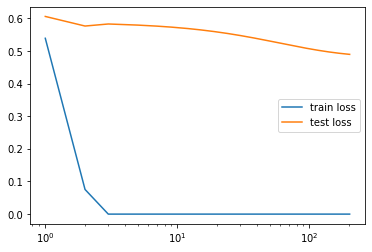

How every weight evolves during training. Dashed lines are trained on first 2 or last 2 envs


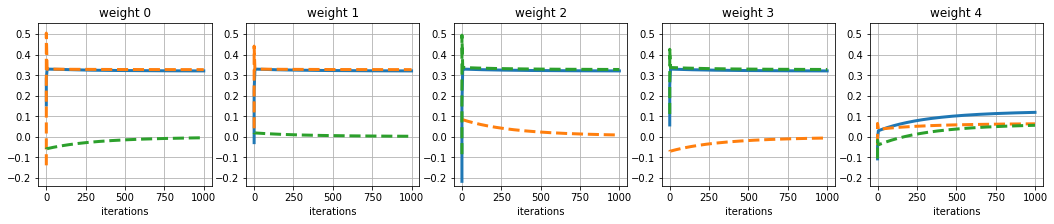

In [18]:
run_method('arithm_mean')

The and-mask (and the geometric mean next) converges to the only solution that is 'visible' to any pair of environments, i.e. approx. [0, 0, 0, 0, 3].
A small amount of weight decay is necessary to get rid of the inconsistent weights.


Method: and_mask = = = Train on all 4 envs
......loss: 0.005745, theta: [ 0.01448 -0.00276 -0.02047  0.00534  3.00852], it: 1000


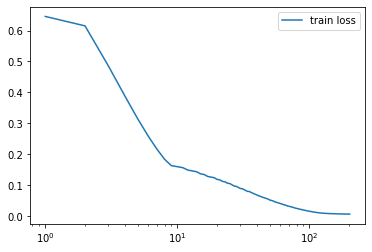


Method: and_mask= = = Train on first 2 envs
......loss: 0.005323, theta: [-0.01314  0.00379  0.00788 -0.00676  3.04676], it: 1000


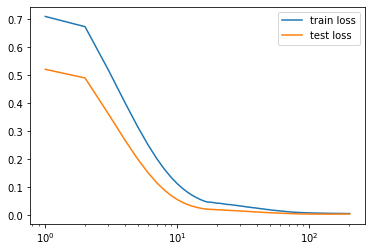


Method: and_mask= = = Train on last 2 envs
......loss: 0.005381, theta: [-0.00561  0.00171 -0.00805  0.01034  2.98854], it: 1000


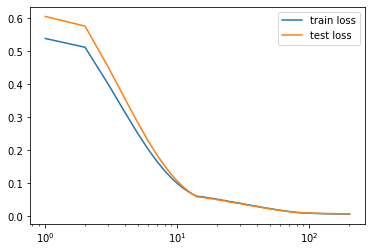

How every weight evolves during training. Dashed lines are trained on first 2 or last 2 envs


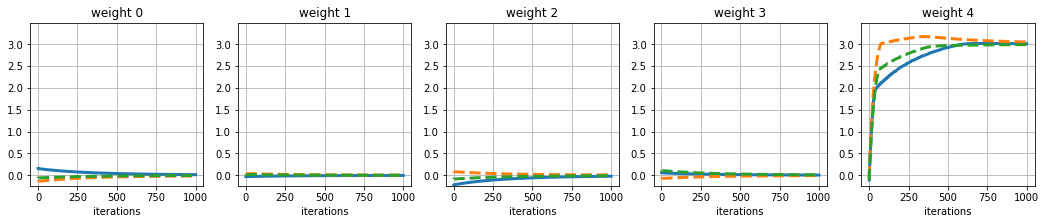

In [19]:
run_method('and_mask')


Method: and_mask_l2 = = = Train on all 4 envs
......loss: 0.014797, theta: [ 0.01448 -0.00276 -0.02047  0.00534  3.00852], it: 1000


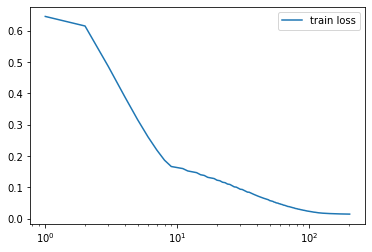


Method: and_mask_l2= = = Train on first 2 envs
......loss: 0.014606, theta: [-0.01314  0.00379  0.00788 -0.00676  3.04676], it: 1000


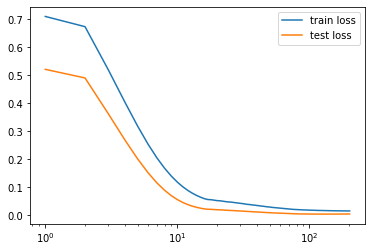


Method: and_mask_l2= = = Train on last 2 envs
......loss: 0.014312, theta: [-0.00561  0.00171 -0.00805  0.01034  2.98854], it: 1000


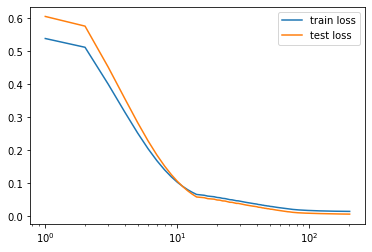

How every weight evolves during training. Dashed lines are trained on first 2 or last 2 envs


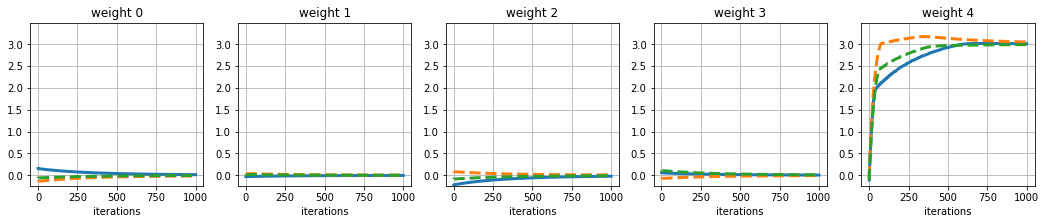

In [25]:
run_method('and_mask_l2')


Method: and_mask_elastic = = = Train on all 4 envs
......loss: 0.134453, theta: [ 0.12392 -0.00492 -0.18476  0.03115  2.10451], it: 1000


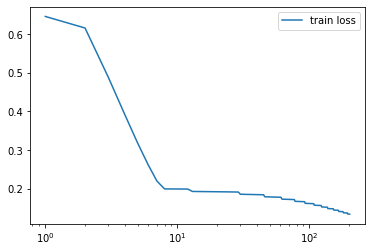


Method: and_mask_elastic= = = Train on first 2 envs
......loss: 0.035715, theta: [-0.11034  0.0154   0.05687 -0.04554  3.18159], it: 1000


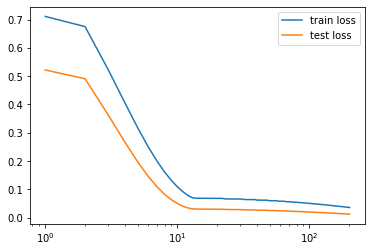


Method: and_mask_elastic= = = Train on last 2 envs
......loss: 0.044296, theta: [-0.03384  0.00002 -0.05864  0.08191  2.51954], it: 1000


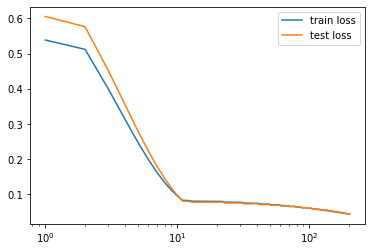

How every weight evolves during training. Dashed lines are trained on first 2 or last 2 envs


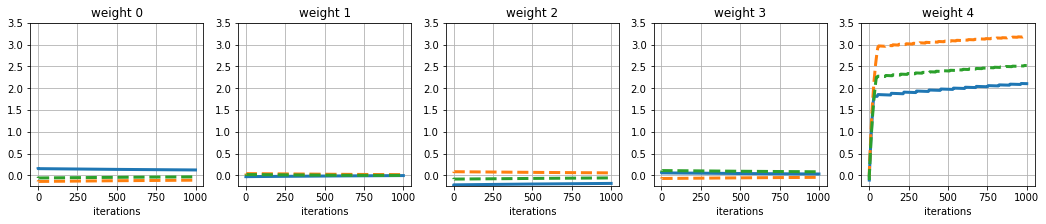

In [30]:
run_method('and_mask_elastic')


Method: geom_mean = = = Train on all 4 envs
......loss: 0.203530, theta: [ 0.1541  -0.02934 -0.21788  0.05684  1.79665], it: 1000


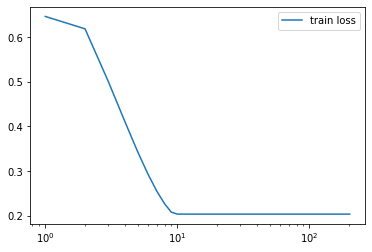


Method: geom_mean= = = Train on first 2 envs
......loss: 0.073037, theta: [-0.13986  0.04033  0.0838  -0.07193  2.93024], it: 1000


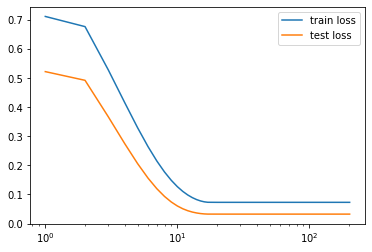


Method: geom_mean= = = Train on last 2 envs
......loss: 0.086167, theta: [-0.05966  0.0182  -0.08567  0.11006  2.23306], it: 1000


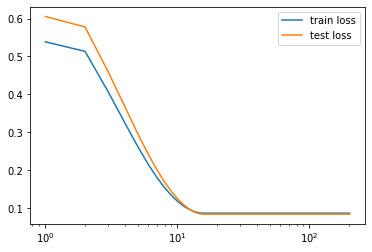

How every weight evolves during training. Dashed lines are trained on first 2 or last 2 envs


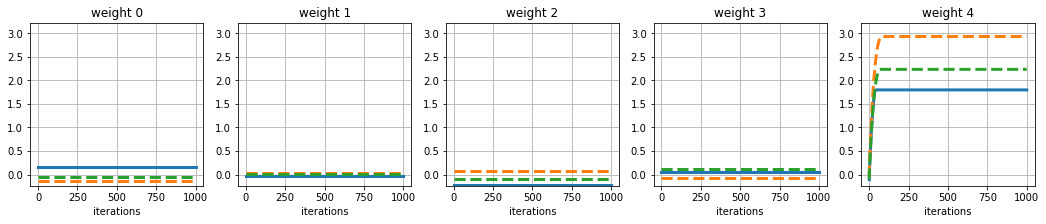

In [31]:
run_method('geom_mean')

To get robust results, we can run things multiple times and average over initializations. For convenience, let's only re-run the case that uses the first 2 environments in training.

=== arithm_mean
......loss: 0.000002, theta: [ 0.32988  0.32988  0.00986 -0.02357  0.02727], it: 500
......loss: 0.000002, theta: [0.32606 0.32606 0.02483 0.02047 0.06546], it: 500
......loss: 0.000002, theta: [ 0.32794  0.32794 -0.0209  -0.00055  0.04667], it: 500
......loss: 0.000002, theta: [0.33163 0.33163 0.00507 0.01434 0.0098 ], it: 500
......loss: 0.000002, theta: [ 0.32827  0.32827 -0.01323  0.00722  0.04343], it: 500
=== and_mask
......loss: 0.005085, theta: [-0.00107  0.00761 -0.0002  -0.02416  2.96727], it: 500
......loss: 0.005163, theta: [-0.00704  0.00501 -0.00579  0.05437  3.01019], it: 500
......loss: 0.005540, theta: [ 0.00166 -0.02025  0.02905  0.07284  3.09295], it: 500
......loss: 0.005259, theta: [-0.02461 -0.03978 -0.01747  0.03496  3.32196], it: 500
......loss: 0.005018, theta: [-0.00753 -0.00353  0.05002  0.0822   3.05527], it: 500
=== and_mask_l1
......loss: 0.005334, theta: [ 0.00008 -0.00019 -0.00006 -0.00017  2.99151], it: 500
......loss: 0.005271, theta: [

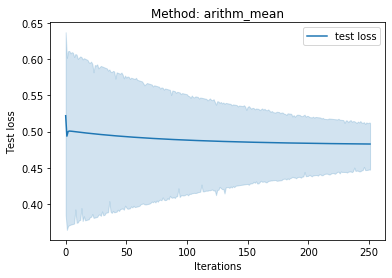

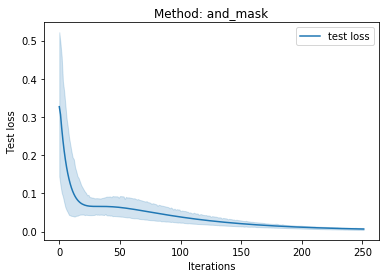

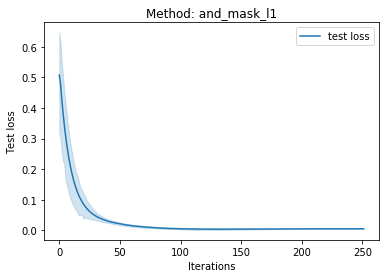

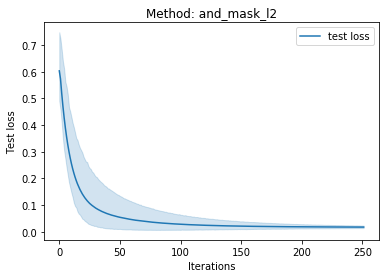

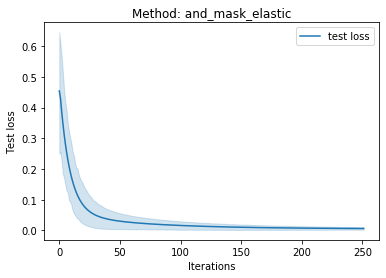

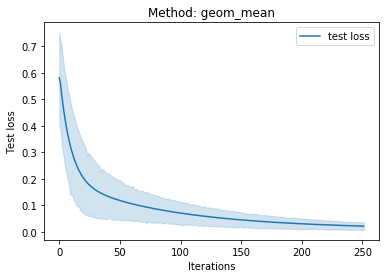

In [32]:
import pandas as pd

def multiple_experiments(n_repetitions, x_train, y_train, x_test, y_test,
                         method, lr, weight_decay, n_iters):
    n_thetas, n_train_losses, n_test_losses = [], [], []
    for i in range((n_repetitions)):
        thetas, iters, train_losses = opt(x_train, y_train, method, lr, 
                                          weight_decay, n_iters, verbose=False)
        test_losses = get_losses(thetas, x_test, y_test)
        n_thetas.append(thetas)
        n_train_losses.append(train_losses)
        n_test_losses.append(test_losses)
    
    n_thetas = np.stack(n_thetas)
    n_train_losses = np.stack(n_train_losses)
    n_test_losses = np.stack(n_test_losses)
    
    return n_thetas, n_train_losses, n_test_losses
        

n_repetitions = 5
lr = .3
weight_decay = .01
n_iters = 500

def run_a_lot(method):
    print(f"=== {method}")
    x_train = x[:2]
    y_train = y[:2]
    x_test = x[2:]
    y_test = y[2:]

    d = multiple_experiments(n_repetitions, x_train, y_train, x_test, y_test,
                             method, lr, weight_decay, n_iters)
    df = pd.DataFrame(d[2]).T
    df.columns = ['test loss' for c in df.columns]
    
    plt.figure()
    sns.lineplot(data=df)
    plt.title(f"Method: {method}")
    plt.ylabel("Test loss")
    plt.xlabel("Iterations")

run_a_lot('arithm_mean')
run_a_lot('and_mask')
run_a_lot('and_mask_l1')
run_a_lot('and_mask_l2')
run_a_lot('and_mask_elastic')
run_a_lot('geom_mean')

Set `ADD_SMALL_NOISE` to `True`, and change the position, sign and amount of noise to see where the and-mask breaks. The geometric mean is slightly more robust than the and-mask, specifically when all signs are positive (then it behaves like GD).